# Lab 1: Nearest Neighbor Regression and Overfitting

This is based on the notebook file [01 in Aurélien Geron's github page](https://github.com/ageron/handson-ml)

In [2]:
import sys
print(sys.version)

3.6.3 |Anaconda custom (64-bit)| (default, Nov  3 2017, 12:34:11) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]


In [2]:
# Import the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import LeaveOneOut
from sklearn import linear_model, neighbors
%matplotlib inline
plt.style.use('ggplot')
sns.set()

# Where to save the figures
PROJECT_ROOT_DIR = ".."
datapath = PROJECT_ROOT_DIR + "/data/lifesat/"

# Load and prepare data

In [5]:
# Download CSV from http://stats.oecd.org/index.aspx?DataSetCode=BLI
oecd_bli = pd.read_csv(datapath+"oecd_bli_2015.csv", thousands=',')
oecd_bli = oecd_bli[oecd_bli["INEQUALITY"]=="TOT"]
oecd_bli = oecd_bli.pivot(index="Country", columns="Indicator", values="Value")

In [6]:
oecd_bli.columns

Index(['Air pollution', 'Assault rate', 'Consultation on rule-making',
       'Dwellings without basic facilities', 'Educational attainment',
       'Employees working very long hours', 'Employment rate', 'Homicide rate',
       'Household net adjusted disposable income',
       'Household net financial wealth', 'Housing expenditure', 'Job security',
       'Life expectancy', 'Life satisfaction', 'Long-term unemployment rate',
       'Personal earnings', 'Quality of support network', 'Rooms per person',
       'Self-reported health', 'Student skills',
       'Time devoted to leisure and personal care', 'Voter turnout',
       'Water quality', 'Years in education'],
      dtype='object', name='Indicator')

In [8]:
oecd_bli.head()

Indicator,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Long-term unemployment rate,Personal earnings,Quality of support network,Rooms per person,Self-reported health,Student skills,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education
Country,,,,,,,,,,,,,,,,,,,,,
Australia,13.0,2.1,10.5,1.1,76.0,14.02,72.0,0.8,31588.0,47657.0,...,1.08,50449.0,92.0,2.3,85.0,512.0,14.41,93.0,91.0,19.4
Austria,27.0,3.4,7.1,1.0,83.0,7.61,72.0,0.4,31173.0,49887.0,...,1.19,45199.0,89.0,1.6,69.0,500.0,14.46,75.0,94.0,17.0
Belgium,21.0,6.6,4.5,2.0,72.0,4.57,62.0,1.1,28307.0,83876.0,...,3.88,48082.0,94.0,2.2,74.0,509.0,15.71,89.0,87.0,18.9
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,...,1.97,17177.0,90.0,1.6,69.0,402.0,14.97,79.0,72.0,16.3
Canada,15.0,1.3,10.5,0.2,89.0,3.94,72.0,1.5,29365.0,67913.0,...,0.90,46911.0,92.0,2.5,89.0,522.0,14.25,61.0,91.0,17.2


In [10]:
# Load and prepare GDP per capita data

# Download data from http://goo.gl/j1MSKe (=> imf.org)
gdp_per_capita = pd.read_csv(datapath+"gdp_per_capita.csv", thousands=',', delimiter='\t',
                             encoding='latin1', na_values="n/a")
gdp_per_capita.rename(columns={"2015": "GDP per capita"}, inplace=True)
gdp_per_capita.set_index("Country", inplace=True)

In [11]:
gdp_per_capita.head()

,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,
Afghanistan,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",599.994,2013.0
Albania,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",3995.383,2010.0
Algeria,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4318.135,2014.0
Angola,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",4100.315,2014.0
Antigua and Barbuda,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",14414.302,2011.0


In [12]:
full_country_stats = pd.merge(left=oecd_bli, right=gdp_per_capita, left_index=True, right_index=True)
full_country_stats.sort_values(by="GDP per capita", inplace=True)
full_country_stats.head()

,Air pollution,Assault rate,Consultation on rule-making,Dwellings without basic facilities,Educational attainment,Employees working very long hours,Employment rate,Homicide rate,Household net adjusted disposable income,Household net financial wealth,...,Time devoted to leisure and personal care,Voter turnout,Water quality,Years in education,Subject Descriptor,Units,Scale,Country/Series-specific Notes,GDP per capita,Estimates Start After
Country,,,,,,,,,,,,,,,,,,,,,
Brazil,18.0,7.9,4.0,6.7,45.0,10.41,67.0,25.5,11664.0,6844.0,...,14.97,79.0,72.0,16.3,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",8669.998,2014.0
Mexico,30.0,12.8,9.0,4.2,37.0,28.83,61.0,23.4,13085.0,9056.0,...,13.89,63.0,67.0,14.4,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",9009.280,2015.0
Russia,15.0,3.8,2.5,15.1,94.0,0.16,69.0,12.8,19292.0,3412.0,...,14.97,65.0,56.0,16.0,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",9054.914,2015.0
Turkey,35.0,5.0,5.5,12.7,34.0,40.86,50.0,1.2,14095.0,3251.0,...,13.42,88.0,62.0,16.4,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",9437.372,2013.0
Hungary,15.0,3.6,7.9,4.8,82.0,3.19,58.0,1.3,15442.0,13277.0,...,15.04,62.0,77.0,17.6,"Gross domestic product per capita, current prices",U.S. dollars,Units,"See notes for: Gross domestic product, curren...",12239.894,2015.0


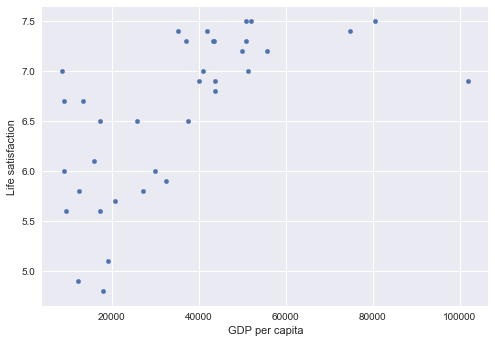

In [4]:
_ = full_country_stats.plot("GDP per capita",'Life satisfaction',kind='scatter')

Here's the full dataset, and there are other columns.  I will subselect a few of them by hand.

In [13]:
xvars = ['Self-reported health','Water quality','Quality of support network','GDP per capita']

In [14]:
X = np.array(full_country_stats[xvars])
y = np.array(full_country_stats['Life satisfaction'])

In [15]:
display(X.shape)
display(y.shape)

(36, 4)

(36,)

I will define the following functions to expedite the LOO risk and the Empirical risk.

In [16]:
def loo_risk(X,y,regmod):
    """
    Construct the leave-one-out square error risk for a regression model
    
    Input: design matrix, X, response vector, y, a regression model, regmod
    Output: scalar LOO risk
    """
    loo = LeaveOneOut()
    loo.get_n_splits(X)
    loo_losses = []
    for train_index, test_index in loo.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        regmod.fit(X_train,y_train)
        y_hat = regmod.predict(X_test)
        loss = np.sum((y_hat - y_test)**2)
        loo_losses.append(loss)
    return np.mean(loo_losses)

def emp_risk(X,y,regmod):
    """
    Return the empirical risk for square error loss
    
    Input: design matrix, X, response vector, y, a regression model, regmod
    Output: scalar empirical risk
    """
    regmod.fit(X,y)
    y_hat = regmod.predict(X)
    return np.mean((y_hat - y)**2)

In [17]:
lin1 = linear_model.LinearRegression(fit_intercept=False)
print('LOO Risk: '+ str(loo_risk(X,y,lin1)))
print('Emp Risk: ' + str(emp_risk(X,y,lin1)))

LOO Risk: 0.348022001422
Emp Risk: 0.2703035744


As you can see, the empirical risk is much less than the leave-one-out risk!  This can happen in more dimensions.

## Nearest neighbor regression

Use the method described here: http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

I have already imported the necessary module, so you just need to use the regression object (like we used LinearRegression)

In [20]:
# knn = neighbors.KNeighborsRegressor(n_neighbors=5)

**Exercise 1** For each k from 1 to 10 compute the nearest neighbors empirical risk and LOO risk. Plot these as a function of k and reflect on the bias-variance tradeoff here. (Hint: use the previously defined functions)

In [41]:
k_range = list(range(1,31))

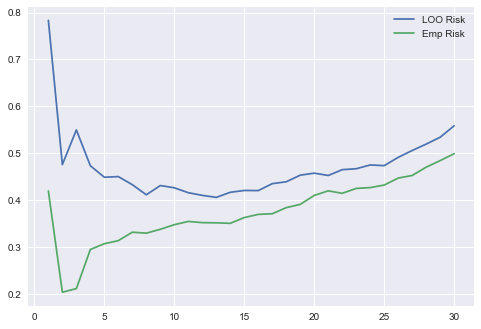

In [42]:
LOO = [loo_risk(X, y, neighbors.KNeighborsRegressor(n_neighbors=k)) for k in k_range]
EMP = [emp_risk(X, y, neighbors.KNeighborsRegressor(n_neighbors=k)) for k in k_range]
plt.plot(k_range, LOO, label='LOO Risk')
plt.plot(k_range, EMP, label='Emp Risk')
plt.legend()

**Exercise 2** Do the same but for the reduced predictor variables below...

In [43]:
X = np.array(full_country_stats[['Self-reported health']])

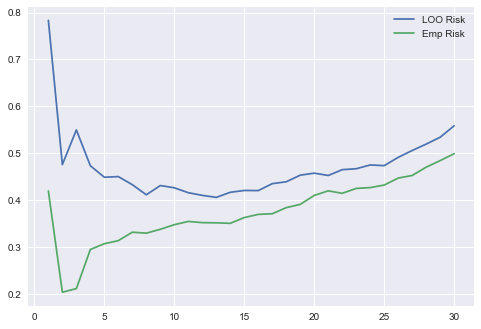

In [44]:
LOO = [loo_risk(X, y, neighbors.KNeighborsRegressor(n_neighbors=k)) for k in k_range]
EMP = [emp_risk(X, y, neighbors.KNeighborsRegressor(n_neighbors=k)) for k in k_range]
plt.plot(k_range, LOO, label='LOO Risk')
plt.plot(k_range, EMP, label='Emp Risk')
plt.legend()